# Database Initialization

In [1]:
from __future__ import division
db = 'twitterGender'
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
myDB = URL(drivername='mysql', database=db, query={ 'read_default_file' : '/home/fatal/.my.cnf' })
engine = create_engine(name_or_url=myDB, encoding='utf8')
#conn = engine.connect()


# Necessary Libraries & Global Variables

In [234]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as ss
import pandas as pd
import warnings
import random

import time
import pdb

#SMALL_VAL = 0.0000001
SMALL_VAL = 1
Zero = 0
RAND_COUNT = 10000
group_id_cnt = 0

# Permutation test to see if the distribution significantly fits a distribution

In [181]:
def fit_permutation_test(N, data, distribution, params, main_ll):
    ll_dist = []
    for i in range(100):
        rand_data = random.sample(data, N)
        res = distribution.logpdf(rand_data, loc=params[-2], scale=params[-1], *params[:-2])
        ll = np.sum(res)
        #excluding_inf = res[(res != float("inf")) & (res != float("-inf"))]
        #ll = np.sum(excluding_inf)
        ll_dist += [ll]
    #pdb.set_trace()
    return main_ll > (np.mean(ll_dist) + 2* np.std(ll_dist))

# Find Best Fit Distribution
## Function name: best_fit_distribution
**Args:**
* data -> a series of data values (like group norms in our case)
* bins -> how many bins we want to divide the data into (default = 200)
* ax -> axes subplots (default None)
  * subplot of the data with x and y limits set
  * If given, this function will add histogram of data + all different distribution lines to this subplot

**Returns:**
* Best_Distribution_name -> winner among all distributions
* Best_SSE -> Minimum sum of squared error
* Best_params -> parameters of the best distribution which has at least two parameters of "Location" and "Scale" + any additional parameters based on the distribution type

**What it does?**
* Creates a histogram of the data divided to <BINS> bins
* Sets x as the center of each bin
* Sets y as the frequency value of each bin (normed = True)
* Finds the best fit distribution among previously defined distributions based on the SSE of the returned value and the actual value
  * Uses scipy.stats distribution methods **fit** and **pdf**
  * scipy.stats current Distributions are **norm**, **expon**, and **lognorm** for now
* If ax is set, it adds histogram and all the distributions lines with their MLE parameters to that

In [248]:
# Create models from data
def best_fit_distribution(input_data, ax=None, plot_pdf = False, test_significance=True):
    """Model data by finding best fit distribution to data"""
    DISTRIBUTIONS = [
        ss.norm, ss.lognorm, ss.expon, ss.powerlaw
    ]
    # Best holders
    best_distribution = ss.norm
    best_params = (0.0, 1.0)
    best_ll = -1 * np.inf
    significant = True

    dist_ll = {}

    N = len(input_data)
    random.shuffle(input_data)
    train_end = int(N/2)
    data = np.sort(input_data[0:train_end])
    test = np.sort(input_data[train_end:N])
    #data = np.sort(input_data)
    #test = np.sort(input_data)
    input_data = np.sort(input_data)
    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                
                # fit dist to data
                params = distribution.fit(data)
                
                ll = np.sum(distribution.logpdf(test, loc=params[-2], scale=params[-1], *params[:-2]))
                #if test_significance:
                #    significant = fit_permutation_test(test, distribution, params)
                dist_ll[distribution.name] = [round(ll, 2), params]
                # if axis pass in add to plot
                try:
                    if ax:
                        # Calculate fitted PDF and error with fit in distribution
                        if plot_pdf:
                            y = distribution.pdf(input_data, loc=params[-2], scale=params[-1], *params[:-2])
                        else:
                            y = distribution.cdf(input_data, loc=params[-2], scale=params[-1], *params[:-2])
                        pd.Series(y, input_data). \
                        plot(ax=ax, label=distribution.name + str(round(ll, 2)))
                except Exception as detail:
                    print('Plotting Runtime Error: ' + str(detail))
                    pass
                # identify if this distribution is better
                if best_ll < ll:
                    best_distribution = distribution
                    best_params = params
                    best_ll = ll

        except Exception as detail:
            print('Runtime Error: ' + str(detail))
            pass

    rands = {}
    for distribution in DISTRIBUTIONS:
        params = dist_ll[distribution.name][1]
        rands[distribution.name] = distribution.rvs(loc=params[-2], scale=params[-1], size=N, *params[:-2])

    for distribution in DISTRIBUTIONS:
        all_except_curr_dist = test
        for k, x in rands.iteritems():
            if k != distribution.name:
                all_except_curr_dist = np.concatenate((all_except_curr_dist, x), axis=0)
        significant = fit_permutation_test(N, all_except_curr_dist, distribution, \
                                           dist_ll[distribution.name][1], dist_ll[distribution.name][0])        
        ks_sig, ks_pval = ss.kstest(test, distribution.name, dist_ll[distribution.name][1])
        ks_res = False
        if ks_pval >= 0.05:
            ks_res = True
        dist_ll[distribution.name] += [str(significant)[0] + str(ks_res)[0]]
            
    return (best_distribution.name, best_ll, best_params, dist_ll)

# Distribution of best fit distributions among all different features

 Gives you count of features in each distribution
 And also best fitted distribution to each feature


In [238]:
def fetch_data(table_name, feat, feat_total_cnt, feat_needed_cnt, use_random=True):
    if use_random and group_id_cnt > RAND_COUNT:
        fetch_data_query = "select * from {0} join \
        (select ceil(rand()*{3}) as id from {0} where feat='{1}') as r2 using(id) limit {2}" \
        .format(table_name, feat, feat_needed_cnt, feat_total_cnt)
    else:
        fetch_data_query = "select * from {0} where feat = '{1}'" \
        .format(table_name, feat)
    raw_df = pd.read_sql(fetch_data_query, con=engine)
    return raw_df
    
    
def prepare_data(table_name, feat, feat_total_cnt, feat_needed_cnt, include_zero=True, use_random=True):
    raw_df = fetch_data(table_name, feat, feat_total_cnt, feat_needed_cnt, use_random)
    data = raw_df.group_norm.tolist()
    total_cnt = group_id_cnt
    if use_random and total_cnt > RAND_COUNT:
        total_cnt = RAND_COUNT
    nonExisting_cnt = max(0, int(total_cnt - len(data)))
    # Appending zero for those that does not use this feature at all
    # By removing this line you can find the best 
    if include_zero:
        data = data + ([Zero]*nonExisting_cnt)
    return np.sort(data).tolist()

def find_best_fit_for_all_feats(table_name, include_zero=True, useAnderson=False, use_random=True):
    pval_threshold = 0.05
    cntr = 1
    usr_best_fit = []
    query_time = 0
    fit_time = 0

    # Load DATA from DB
    stime = time.time()
    global group_id_cnt
    #pdb.set_trace()
    group_id_cnt = pd.read_sql('select count(distinct group_id) cnt from ' + table_name, con=engine)
    group_id_cnt = group_id_cnt.cnt[0]
    print(str(group_id_cnt) + ' data points for each feature')
    print(str(RAND_COUNT) + ' random data points will be selected instead, if it is smaller')
    # Load distinct features
    features = pd.read_sql('select feat, count(*) cnt from ' + table_name + ' group by feat', con=engine)
    feat_cnt = len(features)
    print(str(feat_cnt) + ' unique features' )
        
    if include_zero:
        rand_proportion = min(RAND_COUNT/group_id_cnt, 1)
    else:
        rand_proportion = 1
    #pdb.set_trace()
    # Load data feature by feature and find the best distribution for each feature
    for index, eachfeat in features.iterrows():
        feat = eachfeat.feat
        feat = feat.replace("'", "''").replace("%", "%%").replace('\\', '\\\\')
        qs = time.time()
        feat_datapoint_cnt = int(eachfeat.cnt * rand_proportion)
        data = prepare_data(table_name, feat, eachfeat.cnt, feat_datapoint_cnt, include_zero, use_random)
        qe = time.time()
        best_fit_name, max_ll, best_fit_paramms, dist_stat = best_fit_distribution(data)
        usr_best_fit.append([feat, eachfeat.cnt, feat_datapoint_cnt, best_fit_name, max_ll, best_fit_paramms,\
                            dist_stat])
        beste = time.time()
        query_time += (qe-qs)
        fit_time += (beste-qe)
        x = str(cntr) + ' out of ' + str(feat_cnt) + ', ' + feat + '-> query exec: ' \
        + str(round(qe-qs)) + 's, fit: ' + str(round(beste-qe)) + 's'
        print '\r', x, 
        #print x
        cntr += 1
    etime = time.time()
    print
    print('overall time: ' + str(round(etime-stime)) + 's -> query exec: ' + str(round(query_time)) + \
          's , fit: ' + str(round(fit_time)) + 's') 
    df = pd.DataFrame(usr_best_fit, \
                      columns=['feat', 'total_cnt', 'nonzero_cnt', 'best_fitted',  \
                               'best_statistic', 'best_params', 'dist_stat'])
    feat_dist = df.groupby('best_fitted').feat.count()
    print(feat_dist)

    df = df.sort_values('best_statistic')
    return df

# Draw Two plots for the data
One including all tested distributions and the other the best fitted one

**Args:**
* table_name -> to fetch data from
* feature -> specific feature that we want to fetch data for

**What it does?**
draws two plots for this data
* First one contains all the distributions over the histogram of the data with their MLE parameters.
For this we call function best_fit_distribution with a previously initiated subplot ax with the data ranges.
* Second one contains the winner, the fitted distribution with minimum SSE among all.
For this we generate a pdf out of 10000 samples using the parameters of the winning distribution and draw it.

In [164]:
def draw_plots(data, title, useAnderson=False, plot_pdf=False):
    """Draw plot including real data cdf and also all distributions' cdfs"""
    plt.figure(figsize=(12,8))
    sorted_data = np.sort(data).tolist()
    if plot_pdf:
        plt.hist(sorted_data, bins=200, normed=True, alpha=0.2, color='purple')
    else:
        N = len(sorted_data)
        frequencies = np.arange(1, N+1)/N
        plt.plot(sorted_data, frequencies, color='black', linewidth='3')
        
    ax=plt.subplot(111)
    # Save plot limits
    dataYLim = ax.get_ylim()
    dataXLim = ax.get_xlim()
    
    # Find best fit distribution
    if useAnderson:
        best_fit_name, best_sse, best_fit_paramms, dist_stat = \
        best_anderson_fit_distribution(sorted_data, ax, plot_pdf)
    else:
        best_fit_name, best_sse, best_fit_paramms, dist_stat = best_fit_distribution(sorted_data, ax, plot_pdf)
    ax.legend(loc='upper right')
    best_dist = getattr(ss, best_fit_name)

    # Update plots
    data_array=np.asarray(data)    
    num_of_zeros = len(data_array[data_array==Zero])
    ax.set_ylim(dataYLim)
    ax.set_xlim(dataXLim)
    ax.set_title(str(title) + ',' + best_fit_name + '\n ' + str(num_of_zeros) + '\n All Fitted Distributions')
    ax.set_xlabel('Group Norm')
    ax.set_ylabel('Frequency')
    plt.show()
    plt.close()
    return (best_fit_name, best_sse, best_fit_paramms)


# Putting all together

In [7]:
def dist_plus_nBestWorst(table_name, n=4, include_zero=True, plot_cdf=True, plot_pdf=True, anderson=False):
    df = find_best_fit_for_all_feats(table_name, include_zero, anderson)
    print('\n 4 Best Fitted Distributions')
    for idx, eachRow in df.head(n).iterrows():
        data = prepare_data(table_name, str(eachRow.feat), eachRow.total_cnt, eachRow.nonzero_cnt, include_zero)
        if plot_cdf:
            draw_plots(data, str(eachRow.feat), plot_pdf=False)
        if plot_pdf:
            draw_plots(data, str(eachRow.feat), plot_pdf=True)
    print('\n 4 Worst Fitted Distributions')
    for idx, eachRow in df.tail(n).iterrows():
        data = prepare_data(table_name, str(eachRow.feat), eachRow.total_cnt, eachRow.nonzero_cnt, include_zero)
        if plot_cdf:
            draw_plots(data, str(eachRow.feat), plot_pdf=False)
        if plot_pdf:
            draw_plots(data, str(eachRow.feat), plot_pdf=True)
    return df

# LIWC County Level

999 data points for each feature
10000 random data points will be selected instead, if it is smaller
64 unique features
64 out of 64, YOU-> query exec: 0.0s, fit: 1.0s
overall time: 40.0s -> query exec: 1.0s , fit: 39.0s
best_fitted
expon        9
lognorm     34
norm         1
powerlaw    20
Name: feat, dtype: int64

 4 Best Fitted Distributions


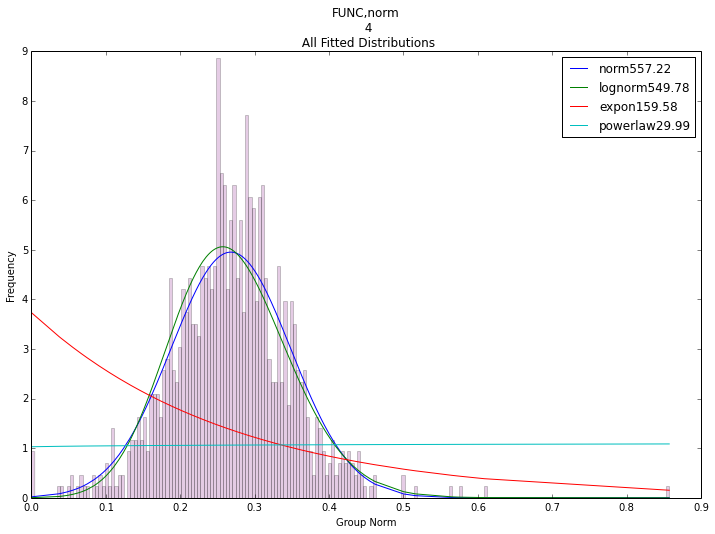

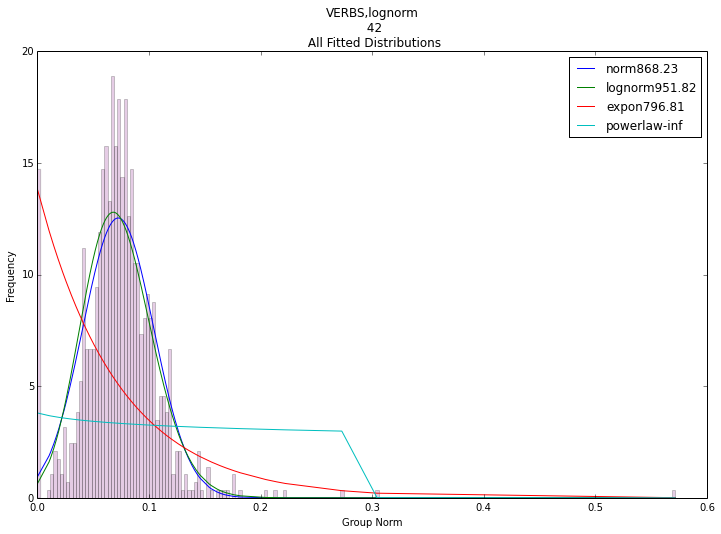

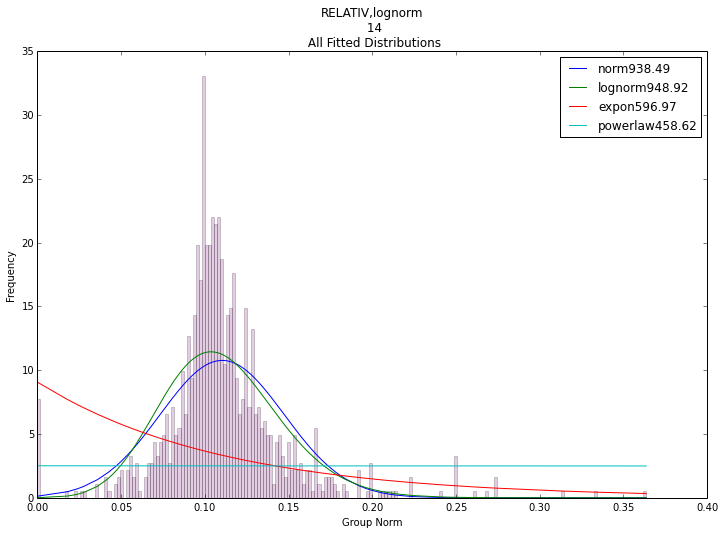

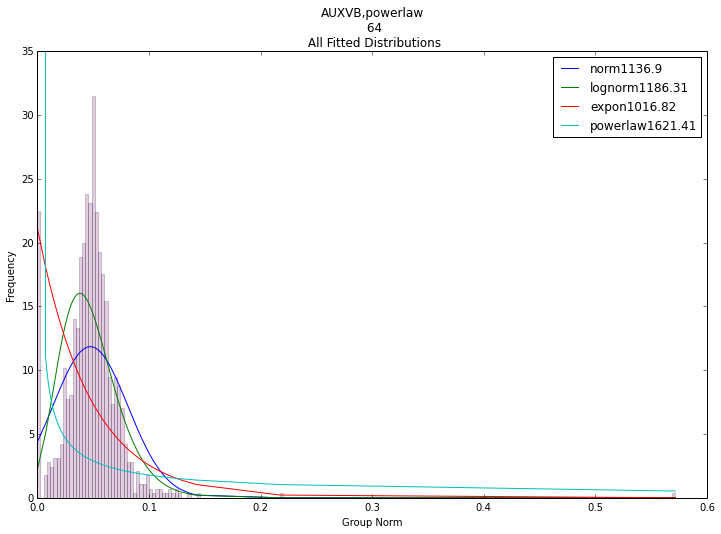


 4 Worst Fitted Distributions


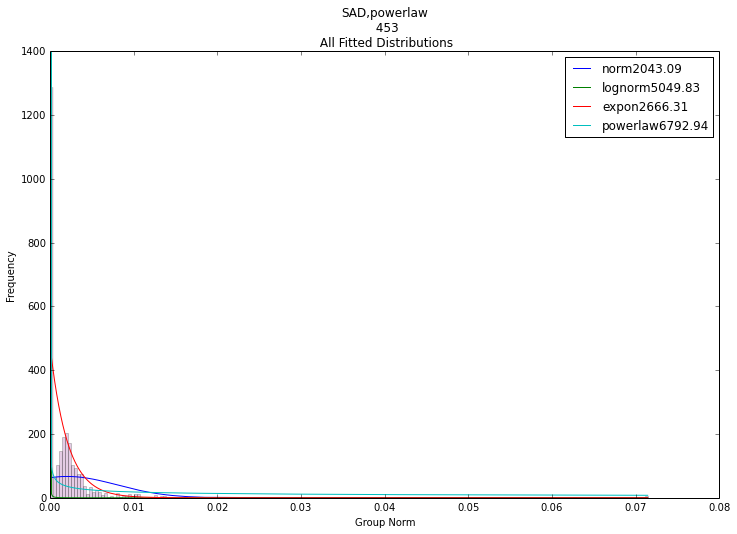

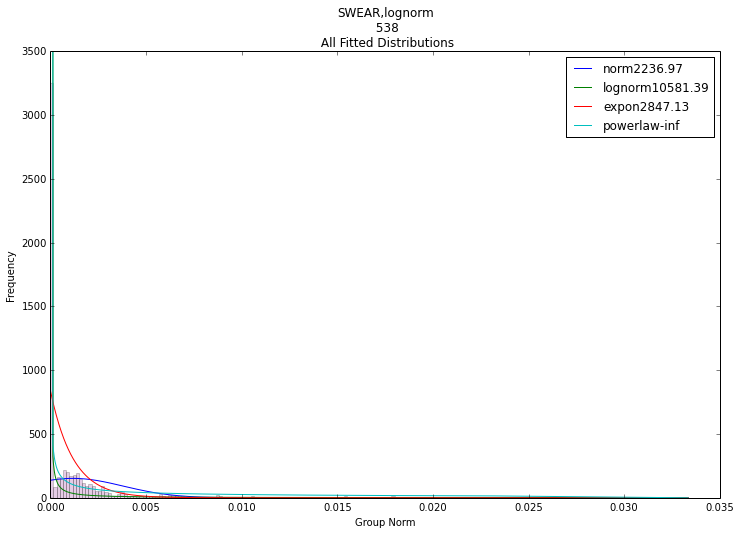

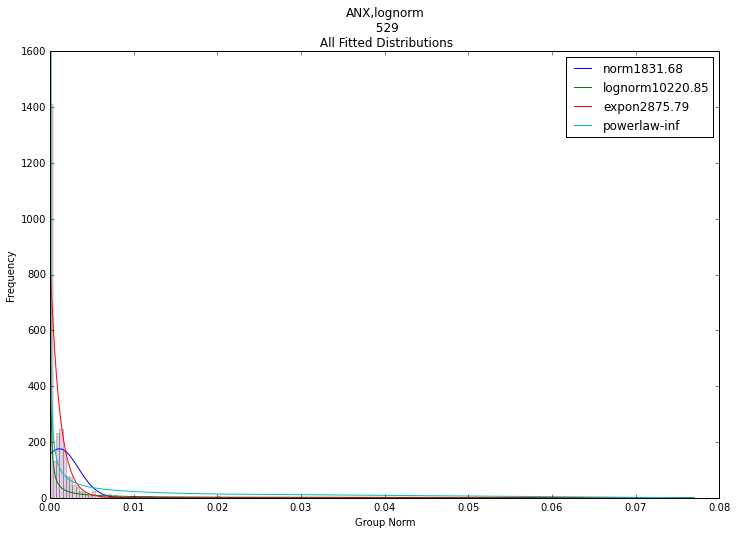

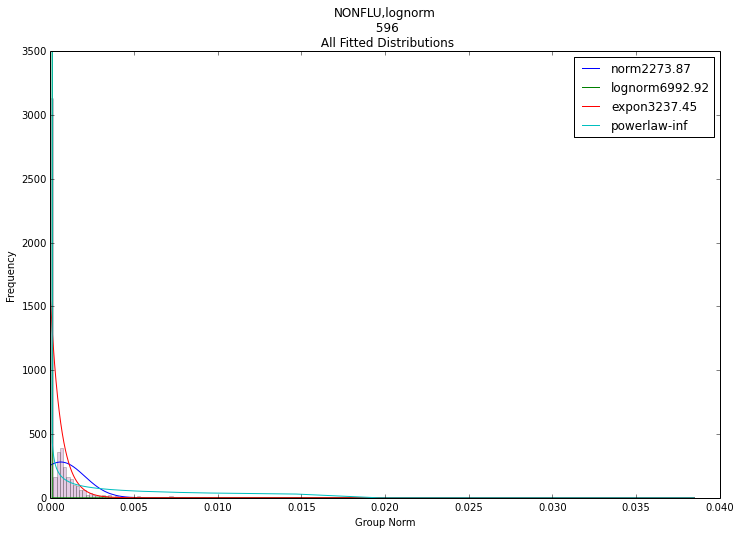

999 data points for each feature
10000 random data points will be selected instead, if it is smaller
64 unique features
64 out of 64, YOU-> query exec: 0.0s, fit: 0.0s
overall time: 31.0s -> query exec: 1.0s , fit: 30.0s
best_fitted
expon       6
lognorm    55
norm        3
Name: feat, dtype: int64

 4 Best Fitted Distributions


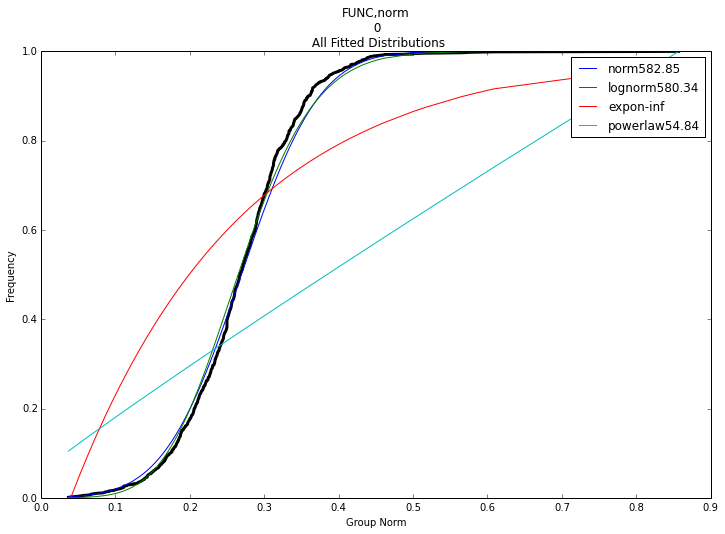

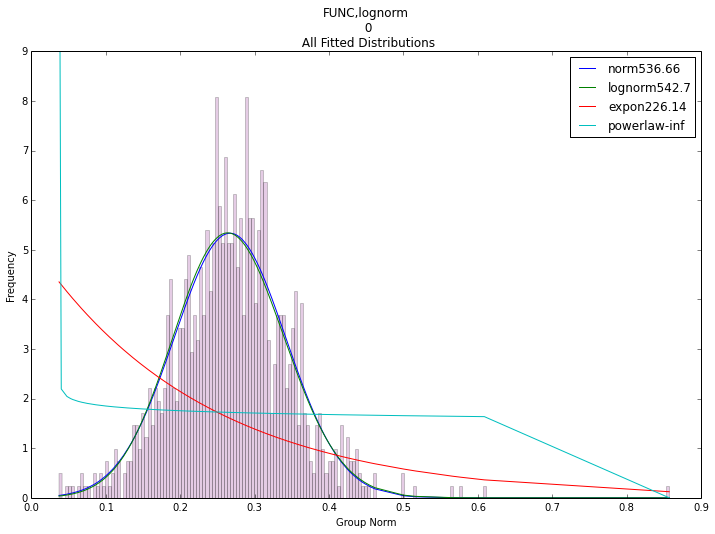

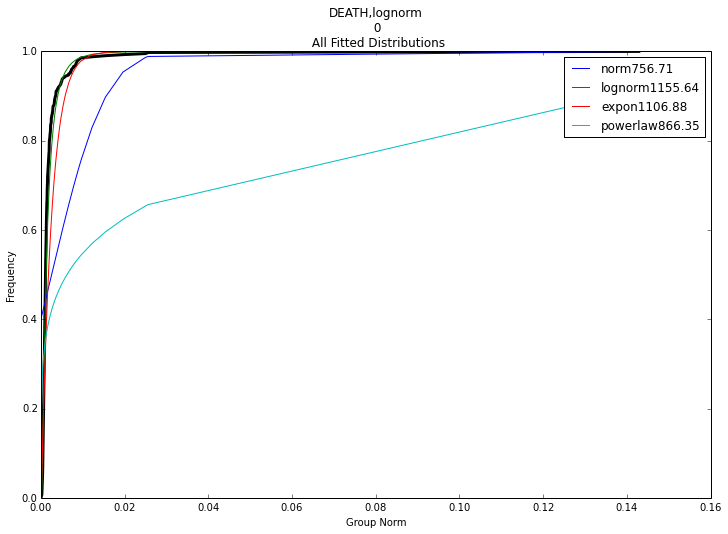

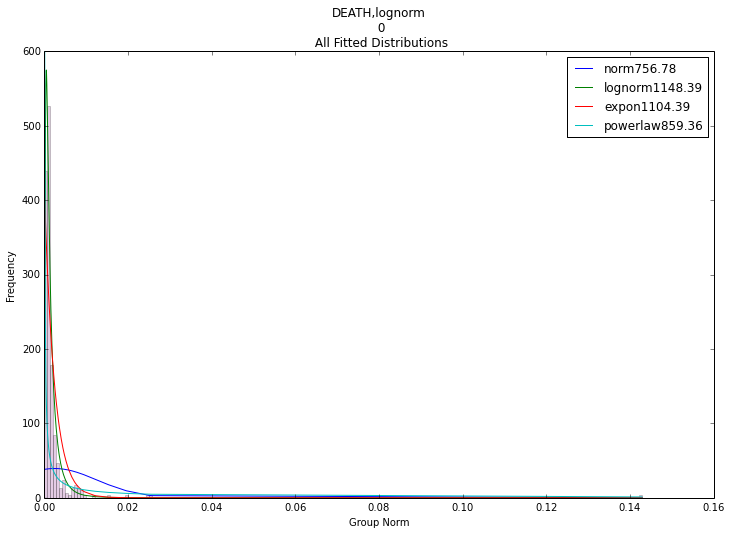

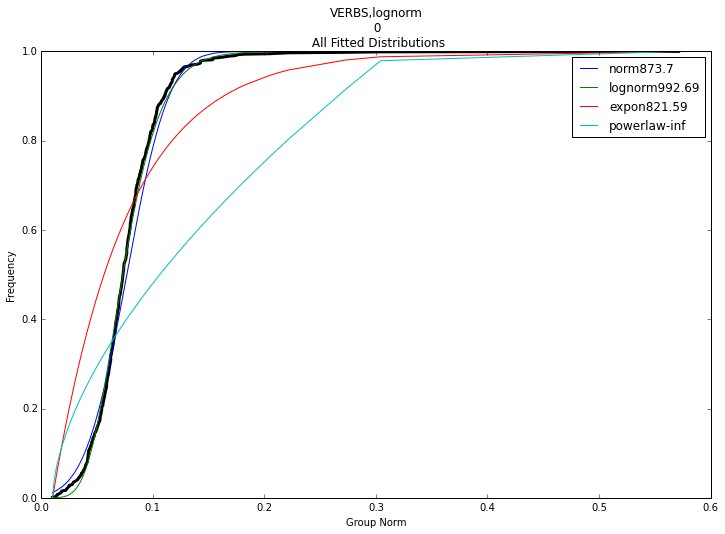

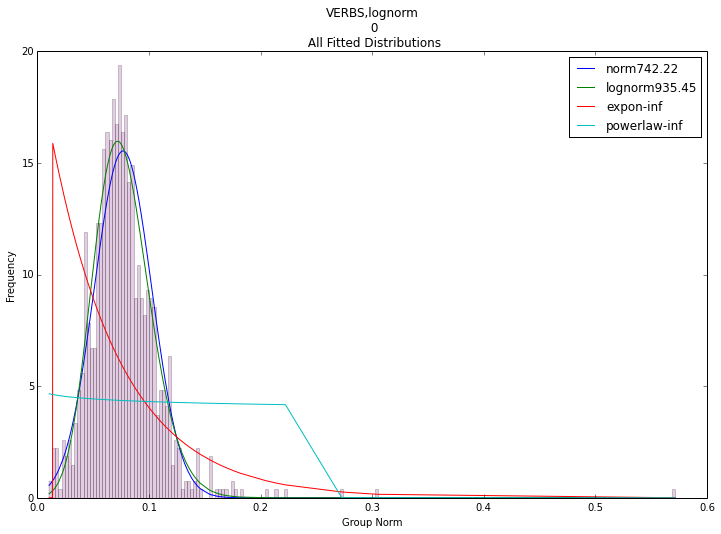

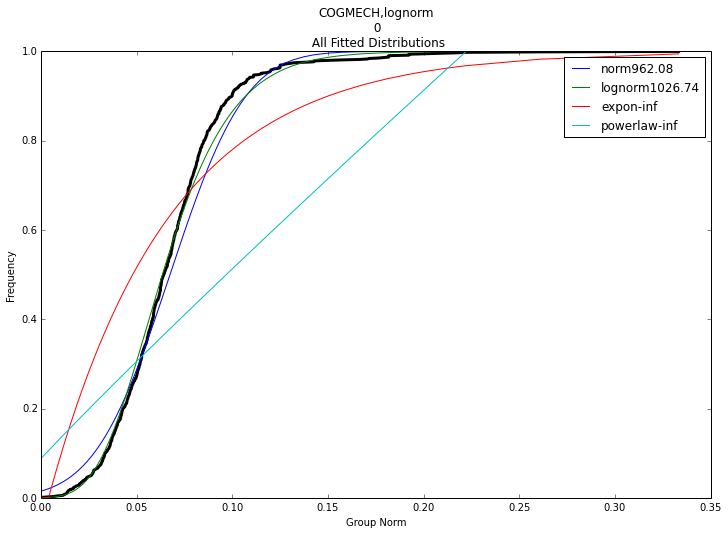

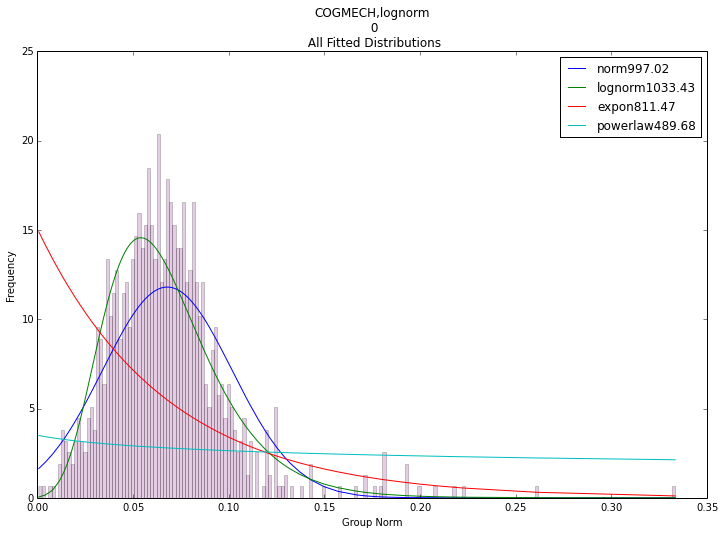


 4 Worst Fitted Distributions


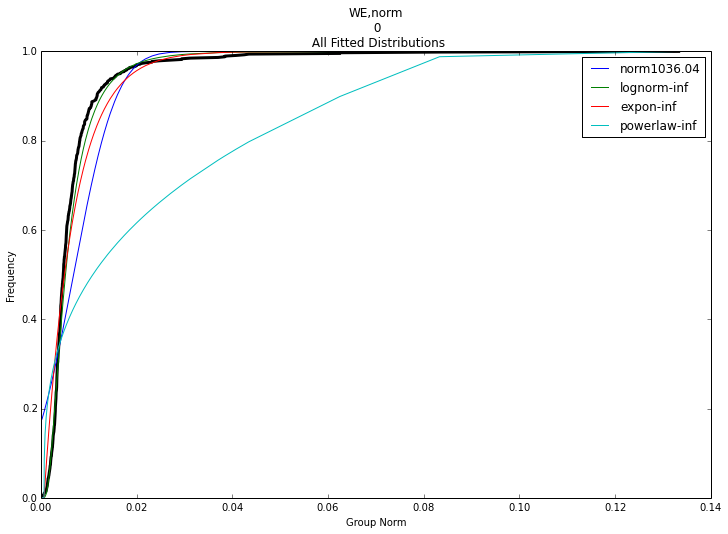

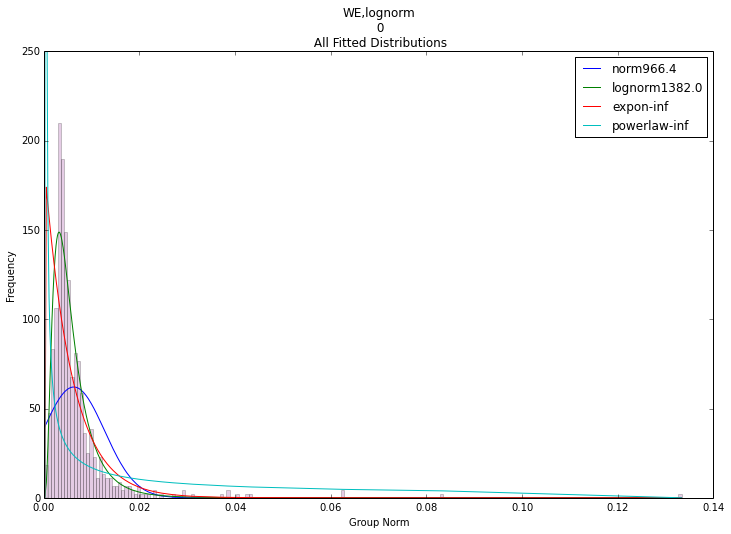

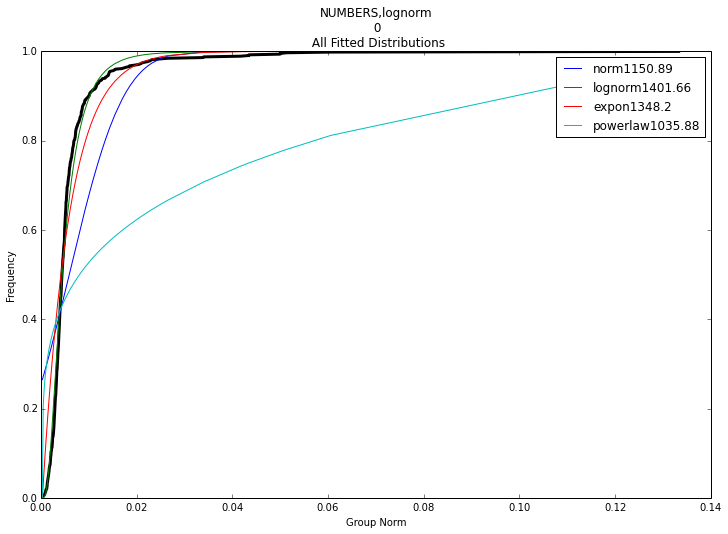

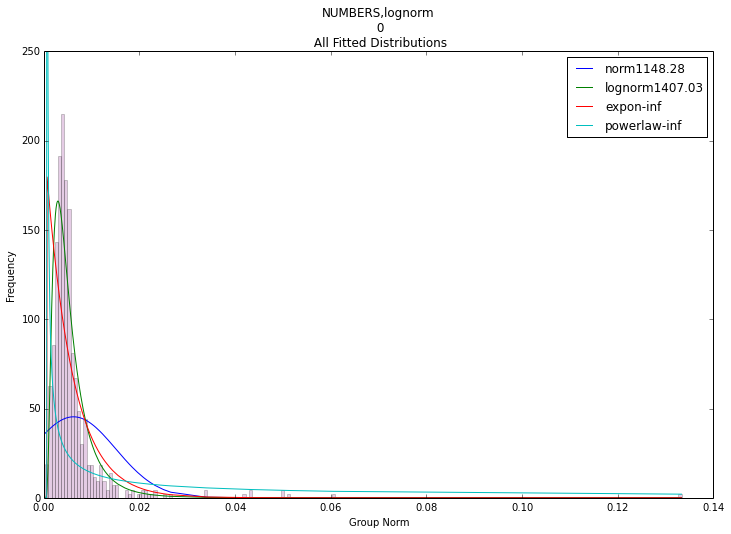

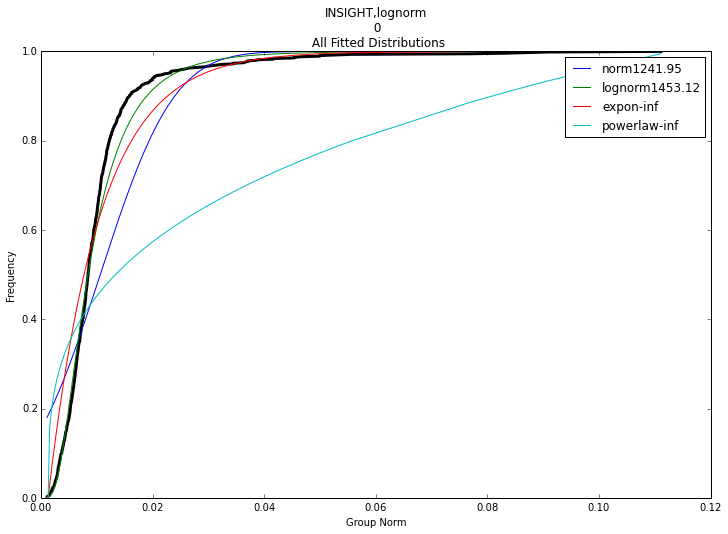

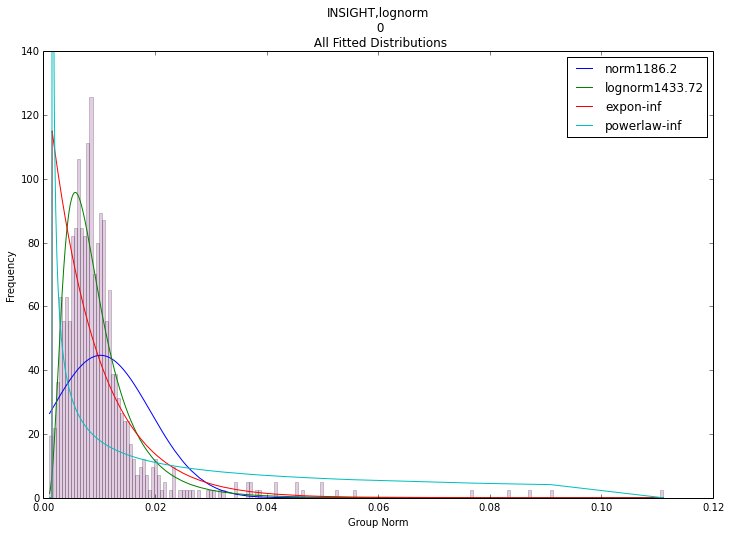

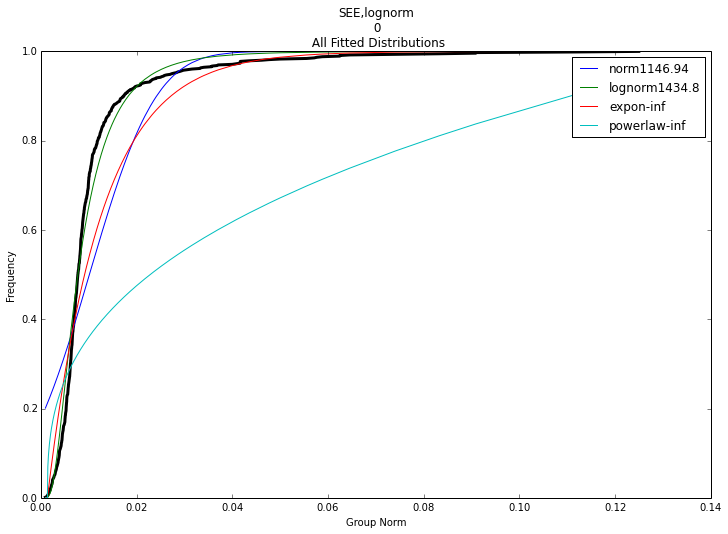

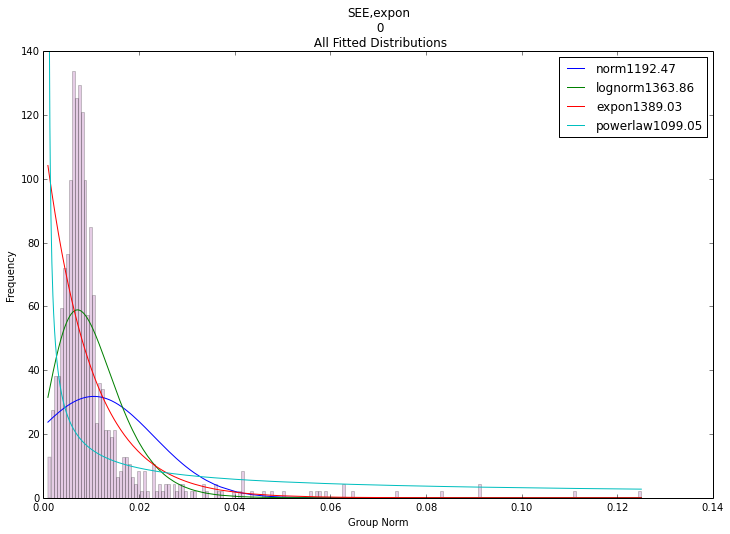

In [281]:
df_liwc_cnty_wZero = dist_plus_nBestWorst('feat$cat_LIWC2007$msgs_cnty_r1k$cnty$16to16', plot_cdf=False)
df_liwc_cnty_noZero = dist_plus_nBestWorst('feat$cat_LIWC2007$msgs_cnty_r1k$cnty$16to16', include_zero=False)

# Results for LIWC features including zeros

In [282]:
cntr = 1
permutation_res = {}
permutation_res['norm'] = 0
permutation_res['lognorm'] = 0
permutation_res['powerlaw'] = 0
permutation_res['expon'] = 0

for idx, x in df_liwc_cnty_wZero.iterrows():
    print cntr,x.feat,
    for k, d in x.dist_stat.items():
        print(k[0] + str(d[2]) + ", "),
        if str(d[2])[0] == "T":
            permutation_res[k] += 1
    print    
    print cntr, x.feat,
    for k, d in x.dist_stat.items():
        print(k[0] + str(d[0]) + ", "),

    print(x.best_fitted)
    print
    cntr+=1
print permutation_res

1 FUNC eFF,  lTF,  pFF,  nTT, 
1 FUNC e157.73,  l565.91,  p30.04,  n568.98,  norm

2 VERBS eFF,  lTT,  pFF,  nTF, 
2 VERBS e806.41,  l954.8,  p-inf,  n874.18,  lognorm

3 RELATIV eFF,  lTF,  pFF,  nTF, 
3 RELATIV e598.03,  l971.33,  p-inf,  n946.26,  lognorm

4 AUXVB eFF,  lFF,  pFF,  nFF, 
4 AUXVB e1005.07,  l926.29,  p-inf,  n852.23,  expon

5 PRONOUN eFF,  lFF,  pFF,  nTF, 
5 PRONOUN e816.0,  l1013.79,  p-inf,  n1008.31,  lognorm

6 COGMECH eFF,  lFF,  pFF,  nTF, 
6 COGMECH e878.42,  l1015.62,  p-inf,  n987.72,  lognorm

7 PREP eFF,  lTF,  pFF,  nTF, 
7 PREP e764.81,  l1086.57,  p709.41,  n1078.48,  lognorm

8 PRESENT eFF,  lTF,  pFF,  nTF, 
8 PRESENT e971.63,  l1120.72,  p-inf,  n1097.35,  lognorm

9 SPACE eFF,  lFF,  pFF,  nTF, 
9 SPACE e902.73,  l1142.29,  p-inf,  n1077.17,  lognorm

10 SOCIAL eFF,  lFF,  pFF,  nFF, 
10 SOCIAL e1117.81,  l1161.17,  p-inf,  n1130.97,  lognorm

11 AFFECT eFF,  lFF,  pFF,  nFF, 
11 AFFECT e1134.8,  l1210.96,  p-inf,  n1142.03,  lognorm

12 TIME eFF,

# Result for LIWC features excluding zeros

In [283]:
cntr = 1
permutation_res = {}
permutation_res['norm'] = 0
permutation_res['lognorm'] = 0
permutation_res['powerlaw'] = 0
permutation_res['expon'] = 0

for idx, x in df_liwc_cnty_noZero.iterrows():
    print cntr,x.feat,
    for k, d in x.dist_stat.items():
        print(k[0] + str(d[2]) + ", "),
        if str(d[2])[0] == "T":
            permutation_res[k] += 1

    print    
    print cntr, x.feat,
    for k, d in x.dist_stat.items():
        print(k[0] + str(d[0]) + ", "),
    print(x.best_fitted)
    print
    cntr+=1
print permutation_res

1 FUNC eFF,  lTT,  pFF,  nTT, 
1 FUNC e225.02,  l526.53,  p-inf,  n523.05,  lognorm

2 DEATH eFF,  lFF,  pFF,  nTF, 
2 DEATH e-inf,  l-inf,  p-inf,  n756.68,  norm

3 VERBS eFF,  lTF,  pFF,  nTF, 
3 VERBS e812.3,  l1020.95,  p-inf,  n876.27,  lognorm

4 COGMECH eFF,  lFT,  pFF,  nTF, 
4 COGMECH e-inf,  l1023.27,  p-inf,  n973.63,  lognorm

5 RELATIV eFF,  lTF,  pFF,  nTF, 
5 RELATIV e-inf,  l1026.26,  p-inf,  n975.34,  lognorm

6 PRONOUN eFF,  lFT,  pFF,  nTF, 
6 PRONOUN e-inf,  l1038.57,  p-inf,  n1015.05,  lognorm

7 SOCIAL eFF,  lFT,  pFF,  nTT, 
7 SOCIAL e972.68,  l1100.57,  p808.84,  n1023.38,  lognorm

8 FRIENDS eFF,  lFF,  pFF,  nFF, 
8 FRIENDS e-inf,  l1106.08,  p-inf,  n749.12,  lognorm

9 HOME eFF,  lFF,  pFF,  nFF, 
9 HOME e-inf,  l-inf,  p-inf,  n1119.25,  norm

10 FEEL eFF,  lFF,  pFF,  nFF, 
10 FEEL e-inf,  l-inf,  p-inf,  n1125.57,  norm

11 SWEAR eFF,  lFF,  pFF,  nFF, 
11 SWEAR e1145.61,  l1099.07,  p-inf,  n935.66,  expon

12 ANX eFF,  lFF,  pFF,  nFF, 
12 ANX e1150.7

# Choose any feature and see plot for that feature distribution.

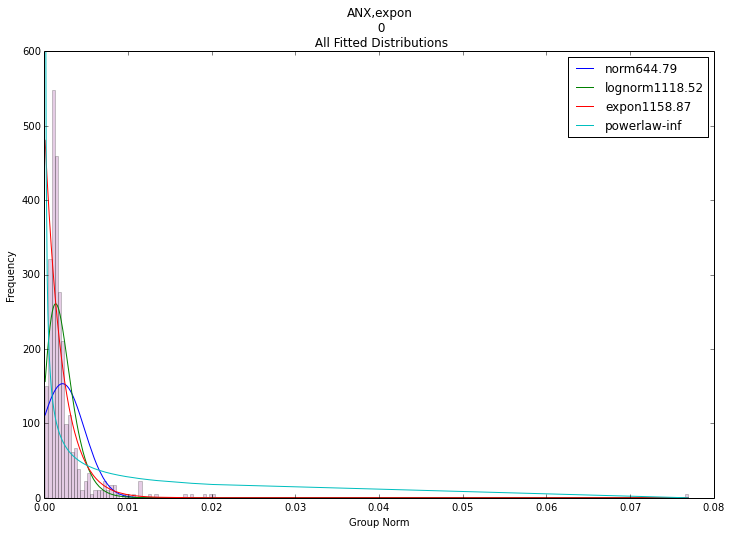

('expon', 1158.8664182733219, (0.00011759044998864763, 0.002081073887484883))

In [254]:
table_name = 'feat$cat_LIWC2007$msgs_cnty_r1k$cnty$16to16'
feat = df_liwc_cnty_noZero[df_liwc_cnty_noZero.feat == 'ANX'].iloc[0]
data = prepare_data(table_name, str(feat.feat), feat.total_cnt, feat.nonzero_cnt, include_zero=False)
draw_plots(data, str(feat.feat), plot_pdf=True)